## 3. Advanced Model Pipeline: Multi-Model Comparison & Ensemble Learning

**Strategy**:
1. **Multiple Base Models**: Test Ridge, Random Forest, Gradient Boosting, and SVR
2. **Ensemble Methods**: Voting Regressor and Stacking Regressor
3. **Hyperparameter Tuning**: GridSearchCV with cross-validation
4. **Bias-Variance Analysis**: Learning curves to diagnose underfitting/overfitting

In [181]:
# Additional Imports for Ensemble Methods
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor, StackingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Additional Feature: Avg Room Size (Proxy for spaciousness)
df['avg_room_size'] = df['size'] / df['room_count']

# Target Transformation
df['log_price'] = np.log1p(df['price'])

# Define Features
features = ['city','region' ,'size', 'room_count', 'bathroom_count', 'avg_room_size']
X = df[features]
y = df['log_price']

# Preprocessing
categorical_cols = ['city','region']
numeric_cols = ['size', 'room_count', 'bathroom_count', 'avg_room_size']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training Set: {X_train.shape[0]} samples | Test Set: {X_test.shape[0]} samples")

Training Set: 793 samples | Test Set: 199 samples


In [182]:
# --- 3.1 Define Base Models with Parameter Grids ---

base_models = {
    'Ridge': {
        'model': Ridge(),
        'params': {
            'model__alpha': [0.1, 1.0, 10.0, 100.0]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(max_iter=5000),
        'params': {
            'model__alpha': [0.1, 0.5, 1.0],
            'model__l1_ratio': [0.2, 0.5, 0.8]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, 20, None],
            'model__min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5, 7]
        }
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(random_state=42),
        'params': {
            'model__n_estimators': [50, 100, 150],
            'model__learning_rate': [0.05, 0.1, 0.5]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['rbf', 'linear'],
            'model__epsilon': [0.1, 0.2]
        }
    }
}

print(f"Testing {len(base_models)} base models with hyperparameter tuning...")

Testing 6 base models with hyperparameter tuning...


### 3.2 Multi-Model Training & Cross-Validation Comparison

In [183]:
# --- Multi-Model Training with GridSearchCV ---

model_results = {}
best_estimators = {}

for name, config in base_models.items():
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    print('='*50)
    
    # Create pipeline for this model
    pipeline = Pipeline([
        ('prep', preprocessor),
        ('model', config['model'])
    ])
    
    # GridSearchCV with 5-fold CV
    grid = GridSearchCV(
        pipeline, 
        config['params'], 
        cv=5, 
        scoring='r2',
        n_jobs=-1,
        return_train_score=True
    )
    
    grid.fit(X_train, y_train)
    
    # Store best estimator
    best_estimators[name] = grid.best_estimator_
    
    # Evaluate on test set
    y_pred = grid.predict(X_test)
    y_pred_real = np.expm1(y_pred)
    y_test_real = np.expm1(y_test)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    
    # Bias-Variance indicators from CV
    cv_train_mean = grid.cv_results_['mean_train_score'][grid.best_index_]
    cv_test_mean = grid.cv_results_['mean_test_score'][grid.best_index_]
    cv_test_std = grid.cv_results_['std_test_score'][grid.best_index_]
    
    model_results[name] = {
        'R2_Test': r2,
        'MAE': mae,
        'RMSE': rmse,
        'CV_Train_R2': cv_train_mean,
        'CV_Test_R2': cv_test_mean,
        'CV_Std': cv_test_std,
        'Bias_Indicator': 1 - cv_train_mean,  # High = underfitting
        'Variance_Indicator': cv_train_mean - cv_test_mean,  # High = overfitting
        'Best_Params': grid.best_params_
    }
    
    print(f"Best Params: {grid.best_params_}")
    print(f"Test R²: {r2:.4f} | MAE: {mae:,.0f} TND | RMSE: {rmse:,.0f} TND")
    print(f"CV Train R²: {cv_train_mean:.4f} | CV Test R²: {cv_test_mean:.4f} ± {cv_test_std:.4f}")

print("\n" + "="*50)
print("All base models trained successfully!")
print("="*50)


Training: Ridge


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/hom

Best Params: {'model__alpha': 1.0}
Test R²: 0.7327 | MAE: 49,096 TND | RMSE: 74,010 TND
CV Train R²: 0.7981 | CV Test R²: 0.7559 ± 0.0144

Training: ElasticNet


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/hom

Best Params: {'model__alpha': 0.1, 'model__l1_ratio': 0.2}
Test R²: 0.6082 | MAE: 54,945 TND | RMSE: 70,382 TND
CV Train R²: 0.6660 | CV Test R²: 0.6587 ± 0.0168

Training: RandomForest


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/hom

Best Params: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Test R²: 0.7216 | MAE: 46,023 TND | RMSE: 67,285 TND
CV Train R²: 0.9178 | CV Test R²: 0.7680 ± 0.0459

Training: GradientBoosting


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/hom

Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
Test R²: 0.7644 | MAE: 43,923 TND | RMSE: 72,406 TND
CV Train R²: 0.9011 | CV Test R²: 0.7877 ± 0.0354

Training: AdaBoost


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/hom

Best Params: {'model__learning_rate': 0.1, 'model__n_estimators': 150}
Test R²: 0.6286 | MAE: 55,735 TND | RMSE: 75,276 TND
CV Train R²: 0.7632 | CV Test R²: 0.7038 ± 0.0430

Training: SVR


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/hom

Best Params: {'model__C': 1, 'model__epsilon': 0.2, 'model__kernel': 'rbf'}
Test R²: 0.7467 | MAE: 44,251 TND | RMSE: 67,075 TND
CV Train R²: 0.8675 | CV Test R²: 0.7709 ± 0.0346

All base models trained successfully!


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### 3.3 Model Comparison: Results & Bias-Variance Analysis


BASE MODEL COMPARISON (Sorted by Test R²)
                  R2_Test         MAE        RMSE  CV_Train_R2  CV_Test_R2  CV_Std  Bias_Indicator  Variance_Indicator
GradientBoosting   0.7644  43922.5488  72405.8838       0.9011      0.7877  0.0354          0.0989              0.1134
SVR                0.7467  44250.9318  67074.9037       0.8675      0.7709  0.0346          0.1325              0.0966
Ridge              0.7327  49095.9141  74010.3075       0.7981      0.7559  0.0144          0.2019              0.0422
RandomForest       0.7216  46023.0329  67285.0050       0.9178      0.7680  0.0459          0.0822              0.1497
AdaBoost           0.6286  55734.9928  75276.4475       0.7632      0.7038  0.0430          0.2368              0.0594
ElasticNet         0.6082  54944.6569  70381.8268       0.6660      0.6587  0.0168          0.3340              0.0073


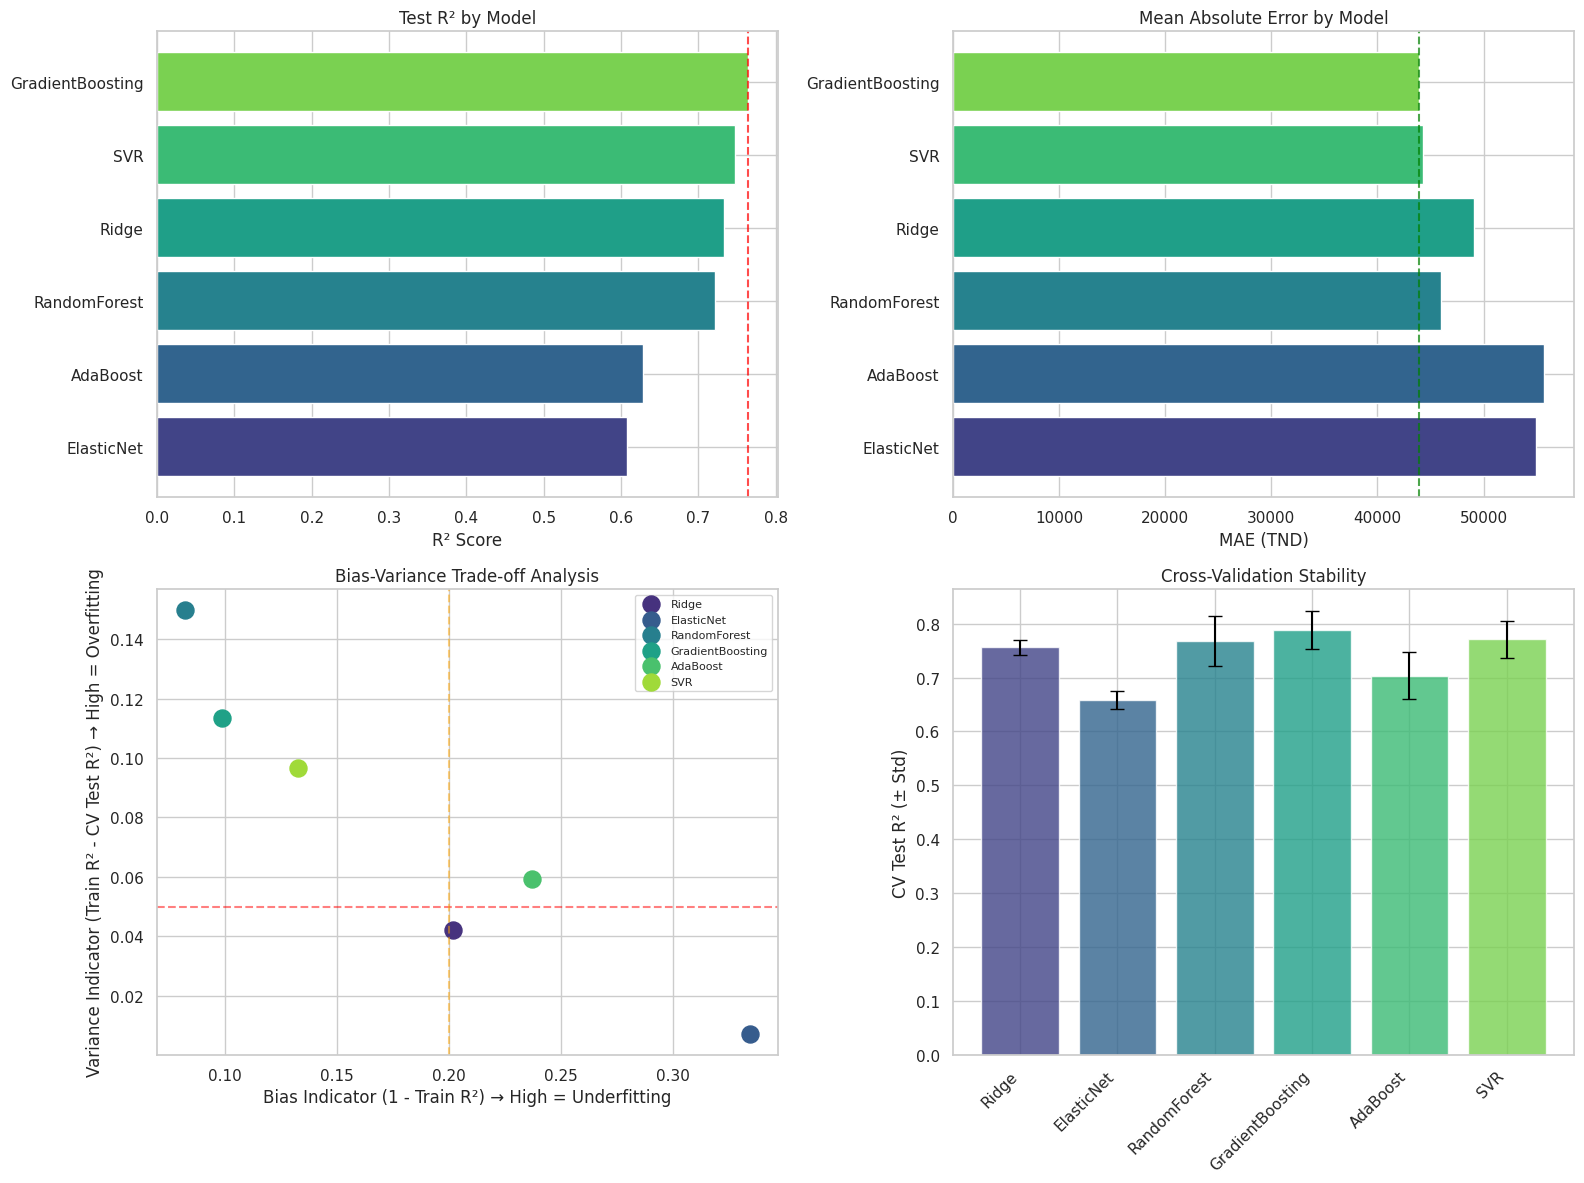


🏆 Best Base Model: GradientBoosting (R² = 0.7644)


In [184]:
# --- Comparison Table ---
comparison_df = pd.DataFrame(model_results).T
comparison_df = comparison_df[['R2_Test', 'MAE', 'RMSE', 'CV_Train_R2', 'CV_Test_R2', 'CV_Std', 'Bias_Indicator', 'Variance_Indicator']]

# Ensure numeric types
numeric_cols_df = ['R2_Test', 'MAE', 'RMSE', 'CV_Train_R2', 'CV_Test_R2', 'CV_Std', 'Bias_Indicator', 'Variance_Indicator']
for col in numeric_cols_df:
    comparison_df[col] = pd.to_numeric(comparison_df[col], errors='coerce')

comparison_df = comparison_df.round(4)

print("\n" + "="*70)
print("BASE MODEL COMPARISON (Sorted by Test R²)")
print("="*70)
print(comparison_df.sort_values('R2_Test', ascending=False).to_string())

# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: R² Comparison
ax1 = axes[0, 0]
models_sorted = comparison_df.sort_values('R2_Test', ascending=True).index
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(models_sorted)))
ax1.barh(models_sorted, comparison_df.loc[models_sorted, 'R2_Test'], color=colors)
ax1.set_xlabel('R² Score')
ax1.set_title('Test R² by Model')
ax1.axvline(x=comparison_df['R2_Test'].max(), color='red', linestyle='--', alpha=0.7, label='Best')

# Plot 2: MAE Comparison  
ax2 = axes[0, 1]
ax2.barh(models_sorted, comparison_df.loc[models_sorted, 'MAE'], color=colors)
ax2.set_xlabel('MAE (TND)')
ax2.set_title('Mean Absolute Error by Model')
ax2.axvline(x=comparison_df['MAE'].min(), color='green', linestyle='--', alpha=0.7, label='Best')

# Plot 3: Bias-Variance Trade-off
ax3 = axes[1, 0]
for i, model in enumerate(comparison_df.index):
    ax3.scatter(comparison_df.loc[model, 'Bias_Indicator'], 
                comparison_df.loc[model, 'Variance_Indicator'],
                s=150, label=model)
ax3.set_xlabel('Bias Indicator (1 - Train R²) → High = Underfitting')
ax3.set_ylabel('Variance Indicator (Train R² - CV Test R²) → High = Overfitting')
ax3.set_title('Bias-Variance Trade-off Analysis')
ax3.legend(loc='upper right', fontsize=8)
ax3.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='Overfitting Threshold')
ax3.axvline(x=0.2, color='orange', linestyle='--', alpha=0.5, label='Underfitting Threshold')

# Plot 4: CV Score with Std
ax4 = axes[1, 1]
x_pos = np.arange(len(comparison_df))
ax4.bar(x_pos, comparison_df['CV_Test_R2'], yerr=comparison_df['CV_Std'], 
        capsize=5, color=colors, alpha=0.8)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax4.set_ylabel('CV Test R² (± Std)')
ax4.set_title('Cross-Validation Stability')

plt.tight_layout()
plt.show()

# Identify best base model
best_base_name = comparison_df['R2_Test'].idxmax()
print(f"\n🏆 Best Base Model: {best_base_name} (R² = {comparison_df.loc[best_base_name, 'R2_Test']:.4f})")